# Сборный проект №2

### Анализ воронки поведения пользователей и проведение А/А/Б теста


**Описание исследования.**
    
Стартап, продающий продукты питания решил проанализировать какие действия совершают пользователи и построить воронку на основе этих данных. Так же, в качестве эксперемента был изменен шрифт для группы пользователей. Необходимо проверить, повлекло ли это нововведение изменение в активности покупателей.
_____
**Цель исследования.**
    
Целью исследования является анализ действий пользователей и построение воронки. Анализ групп А/А/В теста и проверка различий между исследуемыми группами.
    
_____
**Задачи исследования. Первая часть**
В рамках данной работы будут даны ответы на следующие вопросы:

* Сколько всего событий в логе?
* Сколько всего пользователей в логе?
* Сколько в среднем событий приходится на пользователя?
* Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. * * Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные * * полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
* Много ли событий и пользователей вы потеряли, отбросив старые данные?
* Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.
* Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
* Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
* Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
* По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
* На каком шаге теряете больше всего пользователей?
* Какая доля пользователей доходит от первого события до оплаты?

**Задачи исследования. Вторая часть**
* Сколько пользователей в каждой экспериментальной группе?
* Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
* Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
* Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth

### Загрузка и подготовка данных для исследования

In [2]:
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep="\t")
except:
     df = pd.read_csv('/Users/temp/Desktop/projects/logs_exp.csv', sep="\t")

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Исправим заголовки

In [5]:
df = df.rename(columns={'EventName':'event_name','DeviceIDHash':'device_id',
                        'EventTimestamp':'date','ExpId':'group'})

Создадим столбец с датой

In [6]:
df['date_t'] = pd.to_datetime(df['date'],unit='s')

Приведем его к нужному формату

In [7]:
df['date'] = df['date_t'].astype('datetime64[D]')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   device_id   244126 non-null  int64         
 2   date        244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
 4   date_t      244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


Все ОК с датой и временем

Проверим пропуски

In [9]:
df.isna().sum()

event_name    0
device_id     0
date          0
group         0
date_t        0
dtype: int64

Пропусков в данных нет

Изучим данные на наличие явных дубликатов

In [10]:
df.duplicated().sum()

413

Удалим дубликаты

In [11]:
df = df.drop_duplicates().reset_index(drop=True)


In [12]:
df.duplicated().sum()

0

Явных дубликатов нет

Проверим, есть ли одинаковые пользователи в разных группах

In [13]:
df.groupby('device_id').agg({'group' : 'nunique'}).query('group>1').count()

group    0
dtype: int64

Их нет

In [14]:
df['group'] = df['group'].replace(246, 'A1')
df['group'] = df['group'].replace(247, 'A2')
df['group'] = df['group'].replace(248, 'B')

#### Вывод по части подготовки данных

Данные были загружены, приведены к нужному формату, удалены дубликаты, проверены пропуски. Это позволяет продолжать исследование

### Изучение и проверка данных

**Сколько всего событий в логе?**

In [15]:
print('Количество событий в логе:',df['event_name'].nunique())
df['event_name'].unique()

Количество событий в логе: 5


array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Таким образом есть 5 видов событий: Появление основного экрана, Оплата прошла успешно, Появление корзины на экране, Появление товара на экране, Обучение.

**Сколько всего пользователей в логе?**

In [16]:
len(df['device_id'].unique())

7551

Всего 7751 пользователь

**Сколько в среднем событий приходится на пользователя?**

In [17]:
df.groupby(by='device_id').agg({'event_name':'count'}).mean()

event_name    32.275593
dtype: float64

В среднем каждый пользоваль совершает 32 события, но так как среднее - это достаточно спорный показатель, то можно посмотреть также на медиану и на распределение

In [18]:
df.groupby(by='device_id').agg({'event_name':'count'}).median()

event_name    20.0
dtype: float64

50% пользователей совершают 20 событий

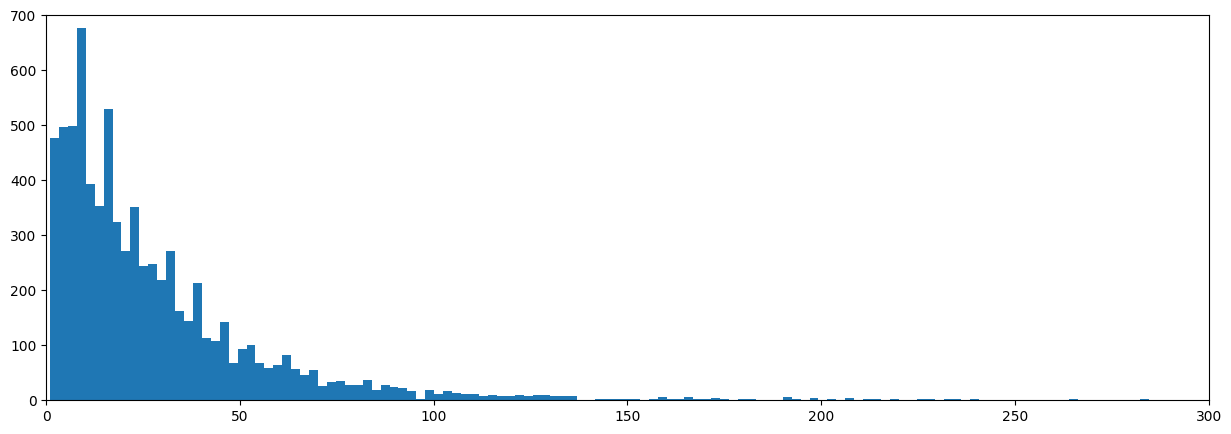

In [19]:
plt.figure(figsize=(15,5))
plt.axis([0,300,0,700])
plt.hist(df.groupby(by='device_id').agg({'event_name':'count'})['event_name'],bins=1000);

Логично, что больше всего пользователей совершают небольшое количество событий и исключением являются те, кто совершает много событий. Чрезмерно большое количество событий у небольшого количества пользователей не отражает реальную динамику событий. Все это влияет на среднее количество.

**Данными за какой период вы располагаете?Найдите максимальную и минимальную дату.**

In [20]:
print('Начало данных', df['date_t'].min())
print('Конец данных', df['date_t'].max())

Начало данных 2019-07-25 04:43:36
Конец данных 2019-08-07 21:15:17


In [21]:
print('Длительность исследования',df['date_t'].max() - df['date_t'].min())

Длительность исследования 13 days 16:31:41


исследование проводилось в течение 2-х недель

**Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период?**

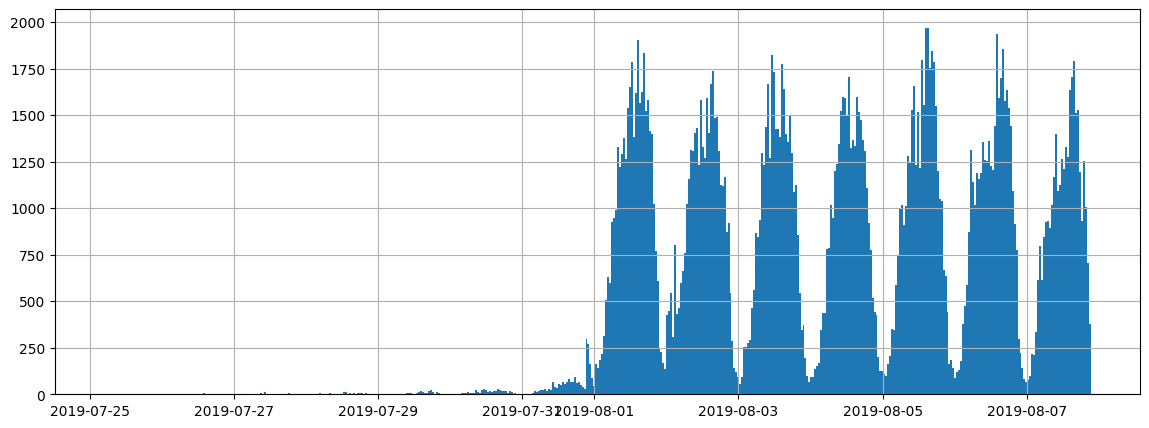

In [22]:
df['date_t'].hist(bins=500, figsize=(14, 5));

Так как исследование начало 25 июля, то в начале посещений практически не было, низкие посещения были с 29 июля по 1 августа. После по каждому дню были высокие посещения. Спады в гистограмме - это видимо ночное время, когда люди спят и не совершают действия на сайте.

Стоит предположить, что исследование было начато не 25 июля, а именно после 1 августа, когда начали изменения в активности. То есть реальная длительность исследования - неделя.

Отсечем ненужны данных

In [23]:
logs = df.loc[df['date'] >= '2019-08-01']

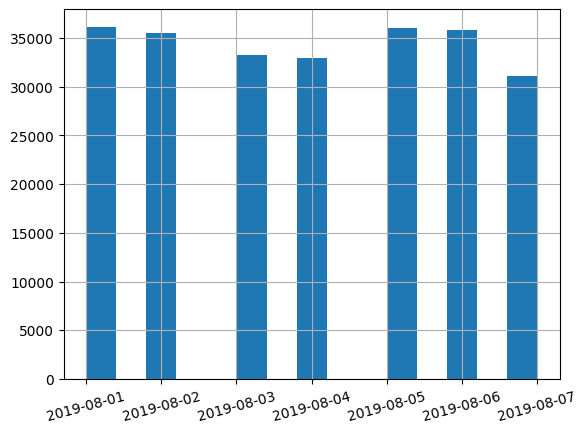

In [24]:
logs['date'].hist(bins = 15)
plt.xticks(rotation = 15) 
plt.show()

По каждому дню примерно одинаковое распределение

**Много ли событий и пользователей вы потеряли, отбросив старые данные?**

In [25]:
print('Доля отброшенных событий',round((1 - len(logs)/len(df)),3))
print('Число отброшенных событий',len(df)-len(logs))
print('Доля отброшенных событий',round((1 - logs['device_id'].nunique()/df['device_id'].nunique()),3))
print('Число отброшенных событий',df['device_id'].nunique()-logs['device_id'].nunique())

Доля отброшенных событий 0.012
Число отброшенных событий 2826
Доля отброшенных событий 0.002
Число отброшенных событий 17


Доли отброшенных событий крайне мала

**Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.**

In [26]:
df.groupby(by='group').agg({'device_id':'nunique'})

,device_id
group,
A1,2489
A2,2520
B,2542


Все три группы представлены в данных и данных по группам разнятся незначительно

## Построение воронок

#### Шаг 4. Изучите воронку событий

**Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.**

In [27]:
logs.groupby(by='event_name').agg({'device_id':'count'}).sort_values(by='device_id',ascending=False)

,device_id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Чаще всего встречается - открытие главного экрана, с этого события начинается знакомство пользователя с приложением. Далее происходит событие - открытие товара, причем число на порядок ниже первого события. Далее идет переход в корзину и проведение оплаты. Обучение - это скорее всего какая-то помощь в использовании приложения, им пользуются крайне мало пользователей, похоже, что все понятно и так.

**Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.**

In [28]:
users = logs.groupby(by='event_name').agg({'device_id':'nunique'}).sort_values(by='device_id',ascending=False)\
                .rename(columns={'device_id':'amount_users'})
users['percent'] = users['amount_users'] / logs['device_id'].nunique()

In [29]:
users

,amount_users,percent
event_name,,
MainScreenAppear,7419,0.984736
OffersScreenAppear,4593,0.609636
CartScreenAppear,3734,0.495620
PaymentScreenSuccessful,3539,0.469737
Tutorial,840,0.111495


Более 98% пользователей зашли на главный экран. 1,1% пользователей не совершали вообще никаких действий в этот период

<BarContainer object of 5 artists>

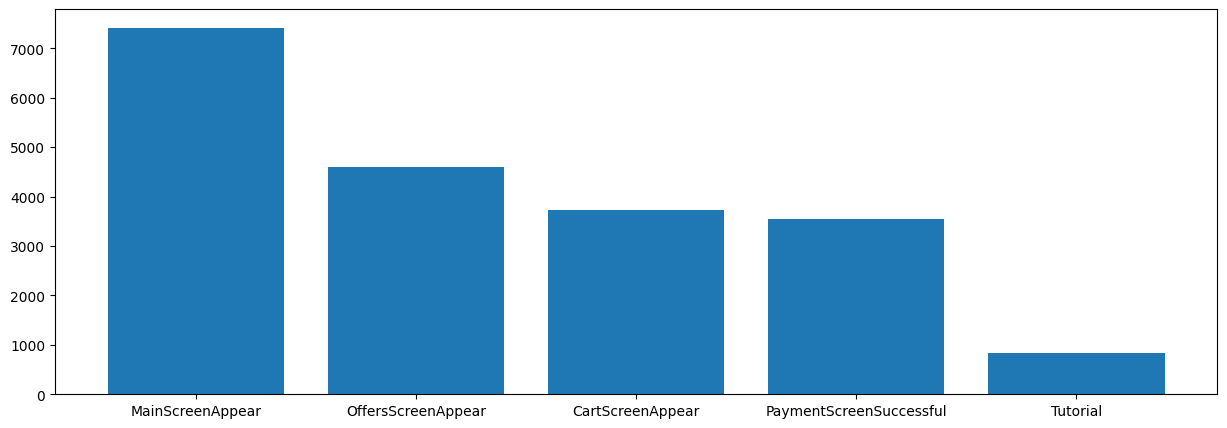

In [30]:
plt.figure(figsize=(15,5))
plt.bar(x=users.index,height=users['amount_users'])

События расположены по убыванию взаимодействия пользователей. Радует то, большинство тех, кто положил товар в корзину, потом совершили покупку

**Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.**

Составим последовательность событий у пользователей
1) Открытие приложения и переход на главный экран\
2) Просмотр товара\
3) Добавление товара в корзину\
4) Оплата товара

Обучение используется редко и связано скорее с поддержкой пользователей в процессе их покупки, если пользователю всё понятно, то он не обратиться за помощью

**По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки**

Исключим обучение, так как это не воронка в привычном для нас понимании

In [31]:
funnel = logs.query('event_name != "Tutorial"')
funnel['event_name'].unique()

array(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
       'PaymentScreenSuccessful'], dtype=object)

In [32]:
funnel = funnel.groupby(by='event_name').agg({'device_id':'nunique'}).sort_values(by='device_id',ascending=False)\
                .rename(columns={'device_id':'amount_users'})
funnel

,amount_users
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539


In [33]:
funnel['retention'] = round(funnel['amount_users']/funnel['amount_users'].shift(1),)*100
funnel['retention_amount'] = funnel['amount_users']-funnel['amount_users'].shift(1)
funnel['conversion'] = round(funnel['amount_users']/logs.query('event_name != "Tutorial"')['device_id'].nunique(),2)*100
funnel

,amount_users,retention,retention_amount,conversion
event_name,,,,
MainScreenAppear,7419,NaN,NaN,99.0
OffersScreenAppear,4593,100.0,-2826.0,61.0
CartScreenAppear,3734,100.0,-859.0,50.0
PaymentScreenSuccessful,3539,100.0,-195.0,47.0


Таким образом, не все пользовали даже переходят на главную страницу. После на страницу товара переходят только 61% от всех пользователей, только 50% добавляют заказ в корзину и 47% оплачивают его. В целом почти половина привлеченных пользователей совершает покупку. Это очень хороший показатель!

Найдем последовательные проценты событий:

In [34]:
funnel_2 = df.pivot_table(
    index='device_id', 
    columns='event_name', 
    values='date_t',
    aggfunc='min')

In [35]:
print('Просмотр главного экрана:', 
      '({:.1%})'.format(funnel_2['MainScreenAppear'].count() / funnel_2['MainScreenAppear'].count() ))
print('Просмотр каталога в % от предыдущего шага:', 
      '({:.1%})'.format(funnel_2['OffersScreenAppear'].count() / funnel_2['MainScreenAppear'].count() ))
print('Просмотр товара в % от предыдущего шага:', 
      '({:.1%})'.format(funnel_2['CartScreenAppear'].count() / funnel_2['OffersScreenAppear'].count()))
print('Оплата в % от предыдущего шага:',
      '({:.1%})'.format(funnel_2['PaymentScreenSuccessful'].count() / funnel_2['CartScreenAppear'].count()))

Просмотр главного экрана: (100.0%)
Просмотр каталога в % от предыдущего шага: (62.0%)
Просмотр товара в % от предыдущего шага: (81.3%)
Оплата в % от предыдущего шага: (94.6%)


Это подтверждает, что больше всего пользователей "теряются" при переходе с главной страницы в каталог для поиска товара. А вот процент тех, кто попал в каталоги потом положил товар в корзину высокий, как и процент оплаты.

**На каком шаге теряете больше всего пользователей?**

В абсолютном значении больше всего пользователей теряются при переходе с главной страницы на страницу товара - это 2826 пользователей. Значит на главной странице их либо ничего не привлекло и они не стали заинтересованы в поиске товара, который был бы им интересен. Было бы здорово, если главная страница были интерактивной с переходами на карточки товаров или с "призом", который может получить пользователь - например, скидку и тд.

**Какая доля пользователей доходит от первого события до оплаты?**

In [36]:
round(funnel['amount_users'][-1]/funnel['amount_users'][0],2)*100

48.0

48% от всех пользователей доходят до оплаты

## Изучение результатов А/А/В теста

**Сколько пользователей в каждой экспериментальной группе?**

Ранее мы их уже находили. Продублируем

In [37]:
logs.groupby(by='group').agg({'device_id':'nunique'})

,device_id
group,
A1,2484
A2,2513
B,2537


Сравним также количество событий по каждой группе, чтобы исключить, что в какой-то группе может быть сильно больше

In [38]:
logs.groupby(by='group').agg({'device_id':'count'})

,device_id
group,
A1,79302
A2,77022
B,84563


В группе В больше действий, но там и больше пользователей, поэтому в целом это может объясняться ростом количества пользователей

**Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.**

In [39]:
df.head()

,event_name,device_id,date,group,date_t
0,MainScreenAppear,4575588528974610257,2019-07-25,A1,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25,A1,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25,B,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25,B,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25,B,2019-07-25 11:48:42


Определим каждую группу

In [40]:
funnel_group = (df.groupby(['event_name', 'group']).agg({'device_id': 'nunique'
                                                        }).reset_index().rename(columns={
    'device_id' : 'total_users'}).sort_values(by=['group','total_users'], ascending=False))

funnel_group = funnel_group[funnel_group['event_name'] != 'Tutorial']
funnel_group

,event_name,group,total_users
5,MainScreenAppear,B,2501
8,OffersScreenAppear,B,1538
2,CartScreenAppear,B,1239
11,PaymentScreenSuccessful,B,1185
4,MainScreenAppear,A2,2482
7,OffersScreenAppear,A2,1530
1,CartScreenAppear,A2,1240
10,PaymentScreenSuccessful,A2,1160
3,MainScreenAppear,A1,2456
6,OffersScreenAppear,A1,1545


В целом, данные группы похожи между собой по количеству пользователей

Функция для z - теста

In [41]:
def z_test (successes1, successes2, trails1, trails2):
        p1 = successes1 / trails1
        p2 = successes2 / trails2
        p_combined = (successes1 + successes2) / (trails1 + trails2)
        difference = p1 - p2 
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trails1 + 1/trails2))
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        alpha = 0.05/16
        print('Событие: {}, p-значение: {p_value:.2f}'.format(event, p_value=p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу о равенстве конверсии в группах")
        else:
            print("Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу")

Вводится поправка Бонферрони bonferroni_alpha = alpha / 12, чтобы снизить риск получения ложного результата

**Гипотезы для сравнения выборок:\
H0: доли уникальных посетителей, которые относятся к одной воронке, одинаковы\
H1: доли уникальных посетителей, которые относятся к одной воронке, отличаются**


Проводим А/А тест

In [43]:
group1 = logs.loc[logs['group']=='A1'].groupby(by='event_name').agg({'device_id':'nunique'})\
                                        .sort_values(by='device_id',ascending=False).rename(columns={'device_id':'users_A1'})
group1['total_users_A1'] = logs.loc[logs['group']=='A1']['device_id'].nunique()
group1

,users_A1,total_users_A1
event_name,,
MainScreenAppear,2450,2484
OffersScreenAppear,1542,2484
CartScreenAppear,1266,2484
PaymentScreenSuccessful,1200,2484
Tutorial,278,2484


In [44]:
group2 = logs.loc[logs['group']=='A2'].groupby(by='event_name').agg({'device_id':'nunique'})\
                                        .sort_values(by='device_id',ascending=False).rename(columns={'device_id':'users_A2'})
group2['total_users_A2'] = logs.loc[logs['group']=='A2']['device_id'].nunique()
group2

,users_A2,total_users_A2
event_name,,
MainScreenAppear,2476,2513
OffersScreenAppear,1520,2513
CartScreenAppear,1238,2513
PaymentScreenSuccessful,1158,2513
Tutorial,283,2513


In [45]:
total = group1.merge(group2, on='event_name')
total.drop(['Tutorial'], inplace=True)
total['A1+A2'] = total['users_A1']+total['users_A2']
total

,users_A1,total_users_A1,users_A2,total_users_A2,A1+A2
event_name,,,,,
MainScreenAppear,2450,2484,2476,2513,4926
OffersScreenAppear,1542,2484,1520,2513,3062
CartScreenAppear,1266,2484,1238,2513,2504
PaymentScreenSuccessful,1200,2484,1158,2513,2358


In [46]:
for event in total.index:
    z_test(total['users_A1'][event],total['users_A2'][event],\
                 total['total_users_A1'][event],total['total_users_A2'][event])

Событие: MainScreenAppear, p-значение: 0.76
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу
Событие: OffersScreenAppear, p-значение: 0.25
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу
Событие: CartScreenAppear, p-значение: 0.23
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу
Событие: PaymentScreenSuccessful, p-значение: 0.11
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу


На заданном уровне значимости нельзя опровегнуть нулевую гипотезу, поэтому нельзя сказать, что есть статистически значимое отличие между группами А1 и А2. Поэтому можно проводить А/В тест

In [47]:
group3 = logs.loc[logs['group']=='B'].groupby(by='event_name').agg({'device_id':'nunique'})\
                                        .sort_values(by='device_id',ascending=False).rename(columns={'device_id':'users_B'})
group3['total_users_B'] = logs.loc[logs['group']=='B']['device_id'].nunique()
group3.drop(['Tutorial'], inplace=True)
group3

,users_B,total_users_B
event_name,,
MainScreenAppear,2493,2537
OffersScreenAppear,1531,2537
CartScreenAppear,1230,2537
PaymentScreenSuccessful,1181,2537


**Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?**

In [48]:
total = group3.merge(total, on='event_name')
total['A1+A2'] = total['users_A1'] + total['users_A2']
total['A1+A2_total'] = logs.loc[logs['group']!= 'B']['device_id'].nunique()
total

,users_B,total_users_B,users_A1,total_users_A1,users_A2,total_users_A2,A1+A2,A1+A2_total
event_name,,,,,,,,
MainScreenAppear,2493,2537,2450,2484,2476,2513,4926,4997
OffersScreenAppear,1531,2537,1542,2484,1520,2513,3062,4997
CartScreenAppear,1230,2537,1266,2484,1238,2513,2504,4997
PaymentScreenSuccessful,1181,2537,1200,2484,1158,2513,2358,4997


In [49]:
for event in total.index:
    z_test(total['users_A1'][event],total['users_B'][event],\
                 total['total_users_A1'][event],total['total_users_B'][event])

Событие: MainScreenAppear, p-значение: 0.29
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу
Событие: OffersScreenAppear, p-значение: 0.21
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу
Событие: CartScreenAppear, p-значение: 0.08
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу
Событие: PaymentScreenSuccessful, p-значение: 0.21
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу


На заданном уровне значимости нельзя опровегнуть нулевую гипотезу, поэтому нельзя сказать, что есть статистически значимое отличие между группами А1 и В. 

In [50]:
for event in total.index:
    z_test(total['users_A2'][event],total['users_B'][event],\
                 total['total_users_A2'][event],total['total_users_B'][event])

Событие: MainScreenAppear, p-значение: 0.46
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу
Событие: OffersScreenAppear, p-значение: 0.92
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу
Событие: CartScreenAppear, p-значение: 0.58
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу
Событие: PaymentScreenSuccessful, p-значение: 0.74
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу


На заданном уровне значимости нельзя опровегнуть нулевую гипотезу, поэтому нельзя сказать, что есть статистически значимое отличие между группами А2 и В. 

In [51]:
for event in total.index:
    z_test(total['A1+A2'][event],total['users_B'][event],\
                 total['A1+A2_total'][event],total['total_users_B'][event])

Событие: MainScreenAppear, p-значение: 0.29
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу
Событие: OffersScreenAppear, p-значение: 0.43
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу
Событие: CartScreenAppear, p-значение: 0.18
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу
Событие: PaymentScreenSuccessful, p-значение: 0.60
Статистическое различие между группами не подтвердилось, не можем отвегнуть нулевую гипотезу


На заданном уровне значимости нельзя опровегнуть нулевую гипотезу, поэтому нельзя сказать, что есть статистически значимое отличие между объединенными группами (А1 + А2) и В. 

**Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.**

Так как было 16 сравнений, то их количество могло повлиять на ошибку первого рода и вероятность ее возникновения. Чтобы появление ошибки первого рода снизилось, то уровень значимости тоже нужно снизить с помощью поправки Бонфирони alpha/16. 

### Вывод по проведенному исследованию

Перед началом исследования данные были обработаны, удалены дубликаты, проверены на наличие пропусков.\
Дата исследования была определена с 1 по 8 августа и длительность исследования составила 1 неделя.\
Были определены 4 ключевых воронки Появление основного экрана, Оплата прошла успешно, Появление корзины на экране, Появление товара на экране. И не ключевое событие – Обучение, которое не было значимым фактом для исследования.\
В среднем каждый пользователь совершал 32 события, но медианное значение ниже – оно составило всего 20.\
Больше всего пользователей теряются в момент, когда после просмотра главного экрана нужно перейти к каталогу. А это значит – есть повод усовершенствовать данное взаимодействие!\
В процессе исследования были выделены 3 группы пользователей с приблизительно равными количествами событий, которые они совершали в приложении.

Для корректности эксперимента сначала был проведен А/А тест, а только потом проведен А/В тест на сравнение экспериментальной группы В с группами А1 и А2.\
По итогу, статистически значимых различий между экспериментальной группой и проверочными группами не оказалось. Поэтому эксперимент стоит прекратить и сделать вывод о том, что введенные изменения никак не повлияли на пользователей и нужно использовать что-то другое


 ### Советы

Нужно настроить главную страницу и слелать удобным переход в каталог. Для этого важно создать некоторый интерактив, чтобы привлечь пользователя в процесс совершения покупки, вызвать у него исследовательский интерес по дальнейшему изучению сайта и каталога. Привратить процесс покупки в интересное приключение для пользователя - важная задача.

Также людей привлекают различные бонусы и скидки, поэтому на главной странице может быть размещена кнопка с выбором товара, на который можно выбрать скидку (например, после регистрации). Или если пользователь постоянный, то он может после какой-то суммы покупки выбирать товар для скидки или же, может быть игра, в которой для пользователя случайным образом выпадает любой товар из каталога, на который будет скидка.

В общем, много всего! Покупатели любят бонусы, так они становятся лояльнее и больше проводят времени на сайте, а нам как раз важно их удержать после просмотра главной страницы.